<b>AML2019</b>

<h3>Challenge 1</h3>
<h1>House Pricing Prediction</h1>
<hr style="height:2px;border:none;color:#333;background-color:#333;"/>
<i>22<sup>th</sup> March 2019</i>

The first AML challenge for this year is adapted from the well-known '<i>Zillow's Home Value Prediction</i>' competition on Kaggle.
In particular, given a dataset containing descriptions of homes on the US property market, your task is to make predictions on the selling price of as-yet unlisted properties. 
Developing a model which accurately fits the available training data while also generalising to unseen data-points is a multi-faceted challenge that involves a mixture of data exploration, pre-processing, model selection, and performance evaluation.

# Overview
<hr style="height:1px;border:none;color:#333;background-color:#333;" />    

Beyond simply producing a well-performing model for making predictions, in this challenge we would like you to start developing your skills as a machine learning scientist.
In this regard, your notebook should be structured in such a way as to explore the five following tasks that are expected to be carried out whenever undertaking such a project.
The description below each aspect should serve as a guide for your work, but you are strongly encouraged to also explore alternative options and directions. 
Thinking outside the box will always be rewarded in these challenges.

In [35]:
#https://www.kaggle.com/mnds18/house-prices-advanced-regression-with-pca

In [36]:
%matplotlib inline
import os
import sys
import re
import random
import matplotlib
import sklearn
from sklearn import preprocessing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from time import time
import seaborn as sns
import scipy
import sklearn.neighbors as neighbors
from scipy import stats
from scipy.stats import skew, norm, probplot, boxcox
from sklearn.preprocessing import RobustScaler 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, SGDRegressor, PassiveAggressiveRegressor, HuberRegressor, BayesianRidge
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, BaggingRegressor, ExtraTreesRegressor
import xgboost as xgb
from xgboost import XGBRegressor


base = "challenge_data/"

<div class="">
    <h3>1. Data Exploration</h3>
</div>

The first broad component of your notebook should enable you to familiarise yourselves with the given data, an outline of which is given at the end of this challenge specification.
Among others, this section should investigate:

- Data cleaning, e.g. treatment of categorial variables;
- Data visualisation;
- Computing descriptive statistics, e.g. correlation.
- etc.

In [37]:
##########################################
############# DATA IMPORT ################
##########################################

house_data = pd.read_csv(base + 'train.csv',keep_default_na=False)

#extract the regressand column and remove it from the train data
prices = house_data.loc[:,"SalePrice"]
train_data = house_data.drop(["Id", "SalePrice"],1) #we also remove the useless ID

train_data[:10]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65,8450,Pave,NA,Reg,Lvl,AllPub,Inside,...,0,0,NA,NA,NA,0,2,2008,WD,Normal
1,20,RL,80,9600,Pave,NA,Reg,Lvl,AllPub,FR2,...,0,0,NA,NA,NA,0,5,2007,WD,Normal
2,60,RL,68,11250,Pave,NA,IR1,Lvl,AllPub,Inside,...,0,0,NA,NA,NA,0,9,2008,WD,Normal
3,70,RL,60,9550,Pave,NA,IR1,Lvl,AllPub,Corner,...,0,0,NA,NA,NA,0,2,2006,WD,Abnorml
4,60,RL,84,14260,Pave,NA,IR1,Lvl,AllPub,FR2,...,0,0,NA,NA,NA,0,12,2008,WD,Normal
5,50,RL,85,14115,Pave,NA,IR1,Lvl,AllPub,Inside,...,0,0,NA,MnPrv,Shed,700,10,2009,WD,Normal
6,20,RL,75,10084,Pave,NA,Reg,Lvl,AllPub,Inside,...,0,0,NA,NA,NA,0,8,2007,WD,Normal
7,60,RL,NA,10382,Pave,NA,IR1,Lvl,AllPub,Corner,...,0,0,NA,NA,Shed,350,11,2009,WD,Normal
8,50,RM,51,6120,Pave,NA,Reg,Lvl,AllPub,Inside,...,0,0,NA,NA,NA,0,4,2008,WD,Abnorml
9,190,RL,50,7420,Pave,NA,Reg,Lvl,AllPub,Corner,...,0,0,NA,NA,NA,0,1,2008,WD,Normal


In [38]:
headers = list(train_data)
i = 1
cat_dict = []
cat_ord_features = ["LotShape",
               "Utilities",
               "LandSlope",
               "ExterQual",
               "ExterCond",
               "BsmtQual",
               "BsmtCond",
               "BsmtExposure",
               "BsmtFinType1",
               "BsmtFinType2",
               "HeatingQC",
               "KitchenQual",
               "Functional",
               "FireplaceQu",
               "GarageFinish",
               "GarageQual",
               "GarageCond",
               "PoolQC"]
cat_ord_dict = {}
categories = []
with open(base + "Data description.rtf") as f:
    i = 0
    begin = False
    feature = ""
    for line in f.readlines()[11:]:
        if line.split()[0] == "\\" and feature != "":
            begin = ~ begin
            if not begin:
                cat_ord_dict[feature].append(np.arange(len(cat_ord_dict[feature][0])-1,-1,-1))
                feature = ""   
        elif cat_ord_features[i] in line:
            feature = cat_ord_features[i]
            cat_ord_dict[feature] = [[]]
            if i < len(cat_ord_features) - 1:
                i += 1
        elif line.split()[0] != "\\" and begin and feature != "":
            cat_ord_dict[feature][0].append(line.split()[0].strip())

In [39]:
#take from ordinal categorical.txt features that have to be converted into numerical value(ex: lotshape, exterquality, ...)
temp_dict = []
for column in cat_ord_dict.keys():
    train_data[column] = train_data[column].replace(to_replace = cat_ord_dict[column][0], value = cat_ord_dict[column][1])
    
for i in range(len(train_data.loc[0])):
    if type(train_data.loc[0][i]) is str:
        cat_dict.append(headers[i])
print(list(cat_dict))

['MSZoning', 'LotFrontage', 'Street', 'Alley', 'LandContour', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'Foundation', 'Heating', 'CentralAir', 'Electrical', 'GarageType', 'GarageYrBlt', 'PavedDrive', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


<list>
    <li>Errors in type recogntion : LotFrontage, MasVnrArea and GarageYrBlt are recognized as a str instead of int. In order to have the possiblity to perform all operatons(correlation, comparison among data, etc.) we convert them into int type, after the remotion of NA value, usually cause of unsuccess in type conversion.
    What, instead, we don't need to convert are the categorical features with NA because, as descripted into the description_file, NA is one of the attribute of some features.</li>
</list>

In [40]:
train_data.LotFrontage = train_data.LotFrontage.replace(to_replace="NA",value = "0")
train_data.MasVnrArea = train_data.MasVnrArea.replace(to_replace="NA",value = "0")
train_data.GarageYrBlt = train_data.GarageYrBlt.replace(to_replace="NA",value = "0")

train_data.LotFrontage = train_data.LotFrontage.astype(errors="ignore",dtype=np.int64)
train_data.MasVnrArea = train_data.MasVnrArea.astype(errors="ignore",dtype=np.int64)
train_data.GarageYrBlt = train_data.GarageYrBlt.astype(errors="ignore",dtype=np.int64)

#reset cat_dict
cat_dict = []
for i in range(len(train_data.loc[0])):
    if type(train_data.loc[0][i]) is str:
        cat_dict.append(headers[i])

#now that we have distinguished numerical and categorical values, we split the original dataset
#this way, we can consider the two cases separately
train_data_cat = train_data[[x for x in cat_dict]]
train_data_num = train_data[[x for x in headers if x not in cat_dict]]

print("%d categorical columns" %len(list(train_data_cat)))
print("%d numerical columns" %len(list(train_data_num)))

25 categorical columns
54 numerical columns


<list>
    <li>
Tutti gli attributi qui sopra hanno NA perchè non hanno quell'oggetto (Garage assente, Alley assente ...)
L'unico che andrebbe corretto è YearBlt poichè è un numero. Settandolo a 0, nella regressione lineare siamo sicuro che non verrà considerato.
    </li>
</list>

Comment about number of null features, percentage, statistics!

REMEMBER TO MAKE AN ATTEMPT WITHOUT REMOVING RECORDS! 

In [41]:
#rebuilt dataframe with saleprice, useful in the next blocks
house_data_num = pd.concat([train_data_num, prices], axis = 1)

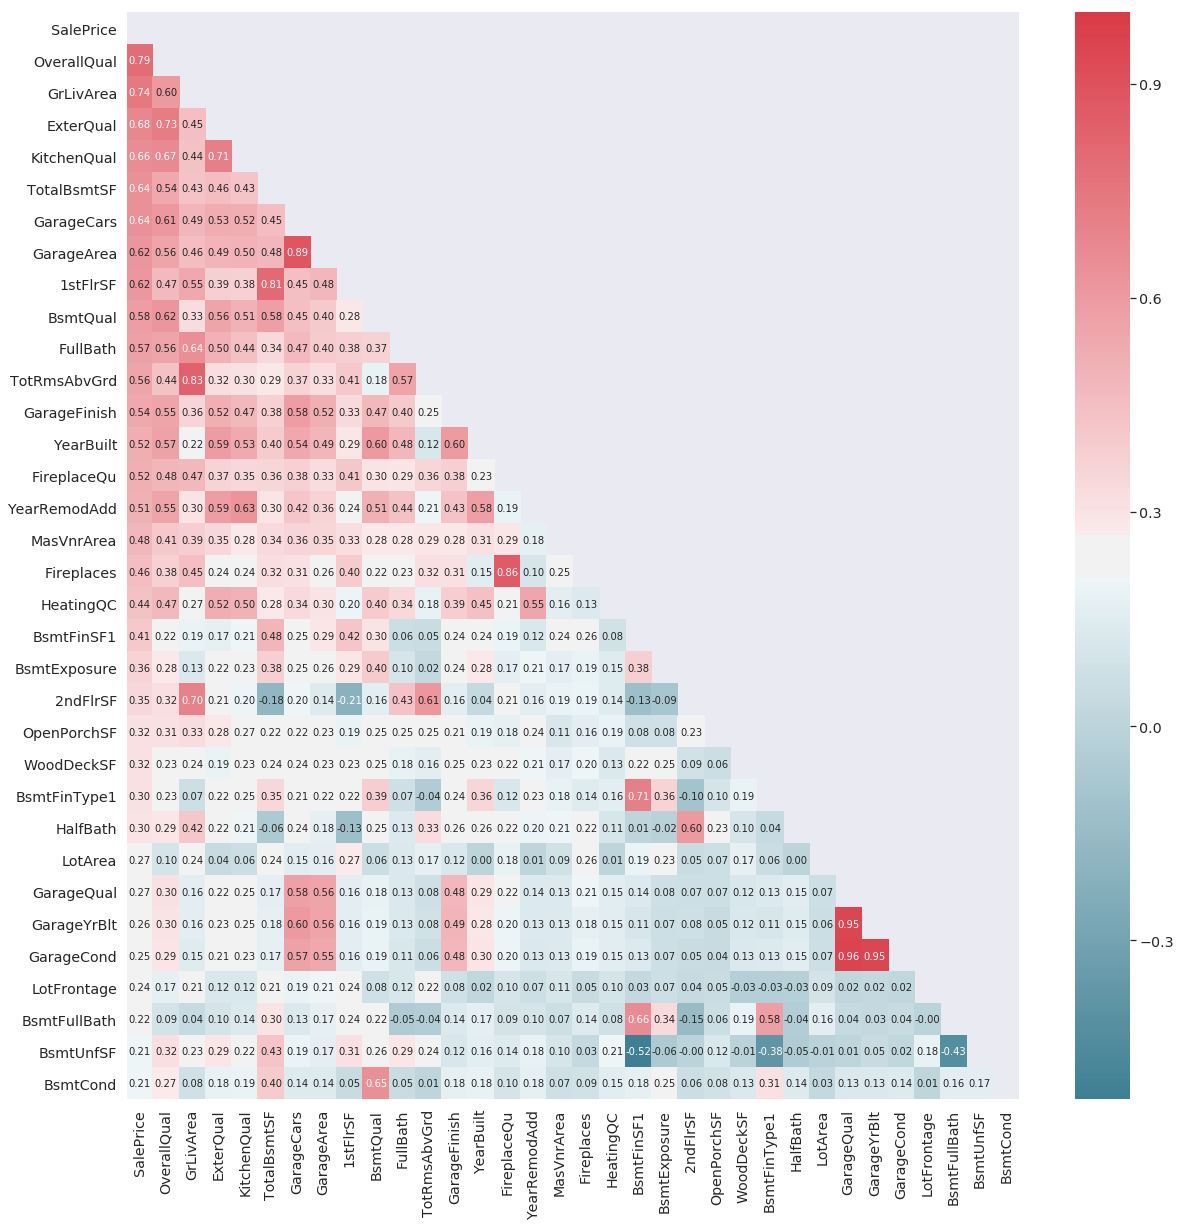

In [42]:
corr = house_data_num.corr()
top_corr_cols = corr[abs((corr.SalePrice)>=.20)].SalePrice.sort_values(ascending=False).keys() #take higher correlation, get rid of very low ones
top_corr = corr.loc[top_corr_cols, top_corr_cols]
dropSelf = np.zeros_like(top_corr)    #fill of zero a matrix of the same shape of topcorr
dropSelf[np.triu_indices_from(dropSelf)] = True 
plt.figure(figsize=(20, 20))
sns.heatmap(top_corr, cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=True, fmt=".2f", mask=dropSelf)
sns.set(font_scale=1.2)
plt.show()

<list>
    What we did here is to show and understand the correlations among all the numerical attributes inside the dataset. The correlation is easaly computable through this kind of data because they give a precise quantity 
    <li>The highest correlation was almost expected because of his own name, an overall quality allows us to understand the full product quality so it's obviously related to that.</li>
<list>

In [43]:
'''
corrSales = house_data_num.corr().loc[:,"SalePrice"].abs()
plt.figure(figsize = (15,5))
plt.title("Correlation between prices and numerical features", fontsize = 20)
plt.xlabel("Feature")
plt.ylabel("Correlation (absolute value)")
plt.bar(range(len(corrSales.index[:-1])), corrSales.values[:-1])
plt.xticks(range(len(corrSales.index[:-1])), corrSales.index[:-1], rotation = 55)
sns.set(font_scale=1.2)
plt.show()

fig, ax = plt.subplots(5,5, figsize = (20,20))
a = 0
b = 0
for key in list(train_data_cat):
    ax[a,b].set_title(key)
    ncat = train_data_cat[key].unique().size
    ax[a,b].bar(range(ncat),
                [(train_data_cat[key] == value).sum() for value in train_data_cat[key].unique()],
                tick_label = train_data_cat[key].unique())
    ax[a,b].set_xticklabels(train_data_cat[key].unique(), rotation = 30)
    if len(train_data_cat[key].unique()) > 20:
        ax[a,b].set_xticklabels(train_data_cat[key].unique(), rotation = 80)
    a += 1
    if a == 5:
        b += 1
        a = 0
'''

'\ncorrSales = house_data_num.corr().loc[:,"SalePrice"].abs()\nplt.figure(figsize = (15,5))\nplt.title("Correlation between prices and numerical features", fontsize = 20)\nplt.xlabel("Feature")\nplt.ylabel("Correlation (absolute value)")\nplt.bar(range(len(corrSales.index[:-1])), corrSales.values[:-1])\nplt.xticks(range(len(corrSales.index[:-1])), corrSales.index[:-1], rotation = 55)\nsns.set(font_scale=1.2)\nplt.show()\n\nfig, ax = plt.subplots(5,5, figsize = (20,20))\na = 0\nb = 0\nfor key in list(train_data_cat):\n    ax[a,b].set_title(key)\n    ncat = train_data_cat[key].unique().size\n    ax[a,b].bar(range(ncat),\n                [(train_data_cat[key] == value).sum() for value in train_data_cat[key].unique()],\n                tick_label = train_data_cat[key].unique())\n    ax[a,b].set_xticklabels(train_data_cat[key].unique(), rotation = 30)\n    if len(train_data_cat[key].unique()) > 20:\n        ax[a,b].set_xticklabels(train_data_cat[key].unique(), rotation = 80)\n    a += 1\n  

Analyze and remove feature high correlated with price, but with outliers.

In [44]:
#MOSTRARE DIFFERENZA SENZA TOGLIERE/TOGLIENDO ELEMENTI A BASSA CORRELAZIONE! (TOGLIENDOLI PEGGIORA)
'''
for feature in corrSales.index.values.tolist():
    if corrSales[feature] < 0.04:
        train_data_num.drop(feature,axis=1)
'''

'\nfor feature in corrSales.index.values.tolist():\n    if corrSales[feature] < 0.04:\n        train_data_num.drop(feature,axis=1)\n'

Comments about high correlation of overall quality of sales price!!!!!!!

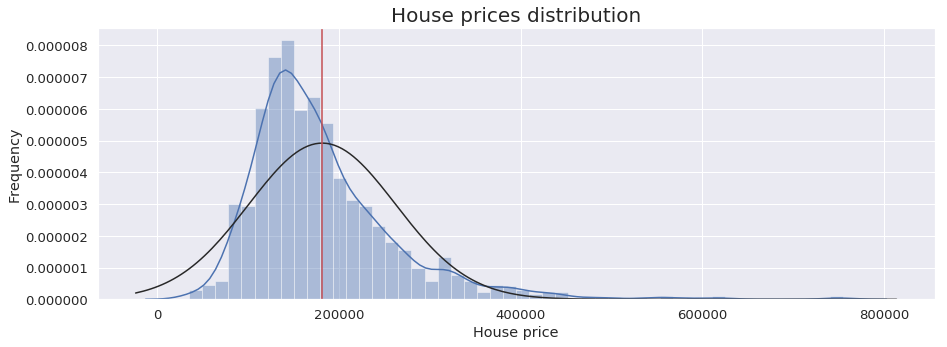

In [45]:
plt.figure(figsize = (15,5))
sns.distplot(prices, bins = 50,fit=norm)
plt.title("House prices distribution", fontsize = 20)
plt.xlabel("House price")
plt.ylabel("Frequency")
plt.axvline(prices.mean(), label='Average price = %.3f' % prices.mean(), color = 'r')
plt.show()

Useful to understand how we have to normalize data, in which direction . . . We notice that the sale prices distribution has an high peak on the left showing how data are skewed, deviating from the normal distribution. 
In the next plot we are gonna produce a normalized structure of the saleprices useful for our analysis, normalization which will be applyed to all numerical columns.

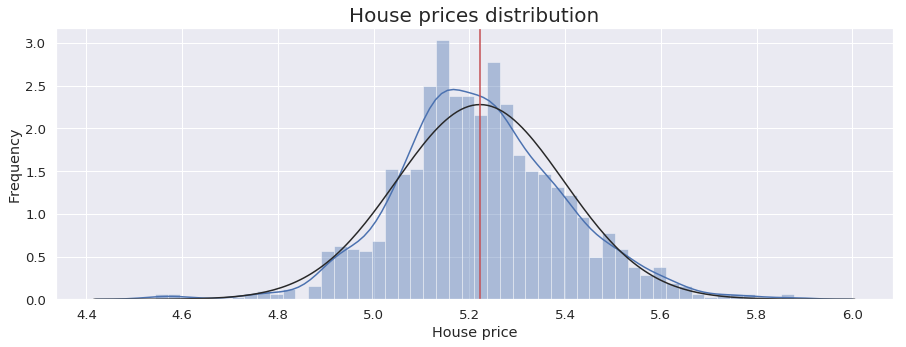

In [46]:
pricesLog = np.log10(prices)
plt.figure(figsize = (15,5))
sns.distplot(pricesLog, bins = 50,fit=norm)
plt.title("House prices distribution", fontsize = 20)
plt.xlabel("House price")
plt.ylabel("Frequency")
plt.axvline(pricesLog.mean(), label='Average price = %.3f' % pricesLog.mean(), color = 'r')
plt.show()

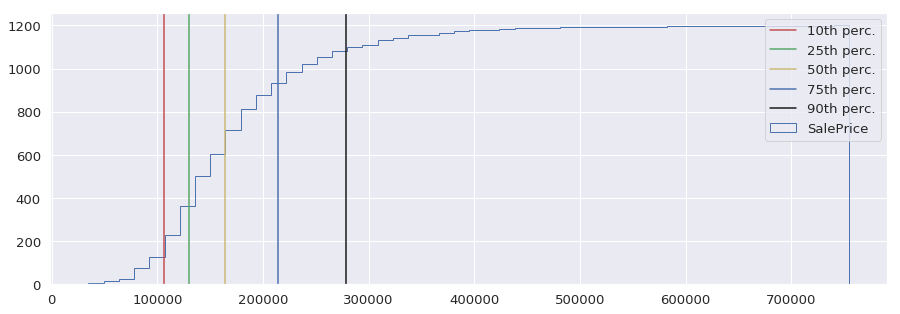

In [47]:
fig, ax = plt.subplots(figsize=(15,5))

# Plot the cumulative distribution
ax.hist(prices,bins=50, cumulative=True, histtype='step')

# Calculate and plot the 5 important percentiles
colors=['r','g','y','b','k']
for i, quantile in enumerate([.1, 0.25, .5, .75, .9]):
    ax.axvline(prices.quantile(quantile), label='%.0fth perc.' % (quantile*100),color=colors[i])
    
ax.legend()
plt.show()

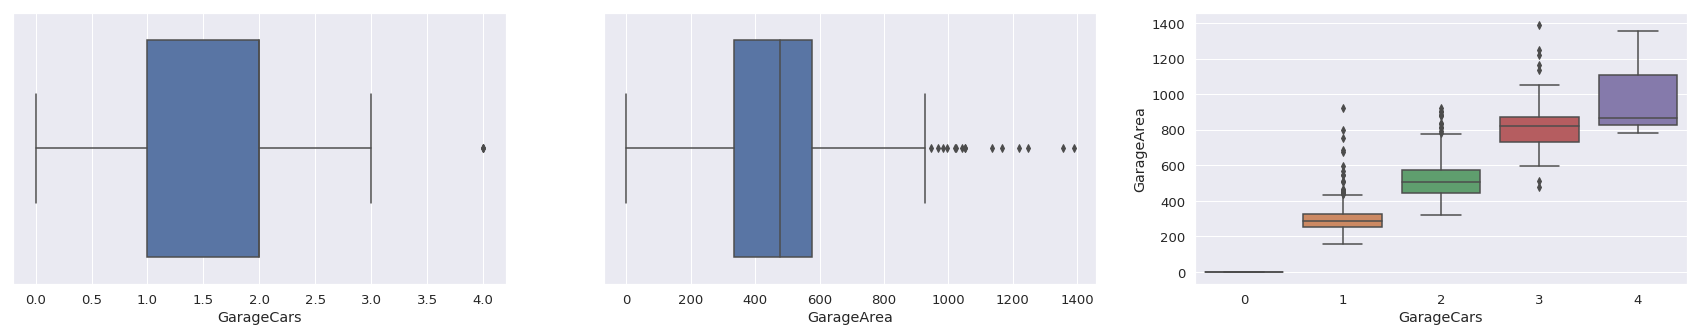

In [48]:
fig = plt.figure(figsize=(30,5))
fig1 = fig.add_subplot(131); sns.boxplot(train_data_num.GarageCars)
fig2 = fig.add_subplot(132); sns.boxplot(train_data_num.GarageArea)
fig3 = fig.add_subplot(133); sns.boxplot(train_data_num.GarageCars, train_data_num.GarageArea)
sns.set(font_scale=1.2)
plt.show()

<list>
<li>The main idea in the correlation analysis has been based on the comparison on pair, focusing on the features with an high correlation, that can be considered as twins and then
keep the one with the highest correlation with the target (saleprice).
Starting from the overall correlation pairwise and then going through the comparison couple by couple we thaught to delete some of the features in order to decrease redundancy,
number of features in order to improve our model.</li>
</list>

In [49]:
#print all couples of correlation > 0.8

In [50]:
#GARAGE CARS AND AREA HAVE A BIG CORRELATION AND BOTH HAVE THE SAME CORREALTION WITH SALESPRICE (0.62 - 0.64) => ONE OF THEM MAY BE REMOVED
if (corr.loc['GarageCars','SalePrice'] > corr.loc['GarageArea','SalePrice']):
    train_data_num.drop('GarageArea', axis = 1)
else: train_data_num.drop('GarageCars', axis = 1)
    
if (corr.loc['GrLivArea','SalePrice'] > corr.loc['TotRmsAbvGrd','SalePrice']):
    train_data_num.drop('TotRmsAbvGrd', axis = 1)
else: train_data_num.drop('GrLivArea', axis = 1)
    
if (corr.loc['TotalBsmtSF','SalePrice'] > corr.loc['1stFlrSF','SalePrice']):
    train_data_num.drop('1stFlrSF', axis = 1)
else: train_data_num.drop('TotalBsmtSF', axis = 1)
    
if (corr.loc['GarageYrBlt','SalePrice'] > corr.loc['YearBuilt','SalePrice']):
    train_data_num.drop('YearBuilt', axis = 1)
else: train_data_num.drop('GarageYrBlt', axis = 1)

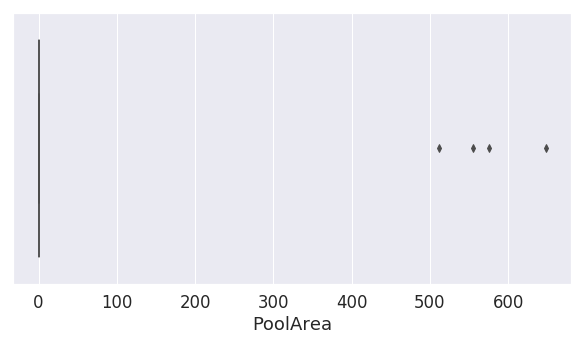

In [51]:
fig = plt.figure(figsize=(10,5))
sns.set(font_scale=1.5)
sns.boxplot(train_data_num.PoolArea)
#sarebbe utile elimarlo??

OUTLIERS: have more than 3 cars and more than 900m area related to few instances with these characteristics.
case of GarageArea 700-900 w.r.t. area for 4 cars. garagearea may be useful for other purposes

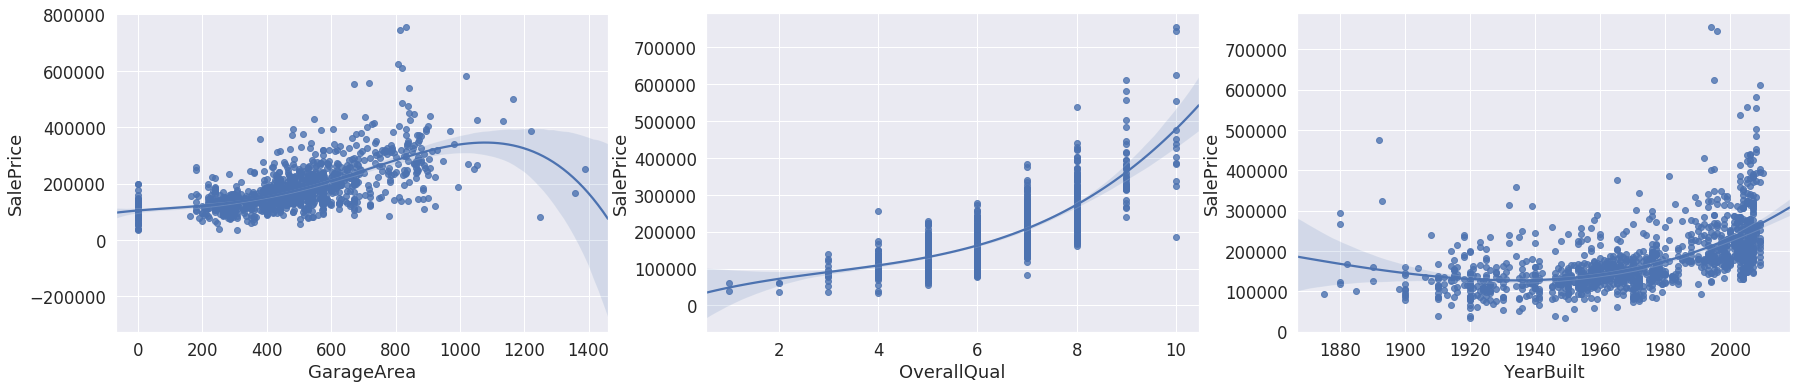

In [52]:
fig = plt.figure(figsize=(30,20))
ax = fig.add_subplot(331); g = sns.regplot(x = house_data_num.GarageArea, y = house_data_num.SalePrice, order=4)
ax = fig.add_subplot(332); g = sns.regplot(x = house_data_num.OverallQual, y = house_data_num.SalePrice,order=3)
fig.add_subplot(333); g = sns.regplot(x = house_data_num.YearBuilt, y = house_data_num.SalePrice, order=3)
sns.set(font_scale=1.3)
plt.show()

<list>
    <li>What we tried to understand in these 3 plots is the difficulty to classify data w.r.t. numerical features, that despite to their numerical representation
    do not give many infomations useful for our model. As we mentioned before, we still need to normalize data, an operation that may help us in order to reduce
    the skewness.
    </li>
    <li>
    We can also how GarageArea does not affect the SalePrice is characterized by many outliers, even if, as for the OverallQuality and the YearBuilt the line increase
    with an evident slope, an expected situation if we think about a bigger garage, and epecially a OverallQual that, as we have seen, has the highest
    correlation with the salesprice.
 </li>
</list>

<div class="">
    <h3>2. Data Pre-processing</h3>
</div>

The previous step should give you a better understanding of which pre-processing is required for the data.
This may include:

- Normalising and standardising the given data;
- Removing outliers;
- Carrying out feature selection, possibly using metrics derived from information theory;
- Handling missing information in the dataset;
- Augmenting the dataset with external information;
- Combining existing features.

<list>
<li>OUTLIERS ELIMINATION</li>
</list>

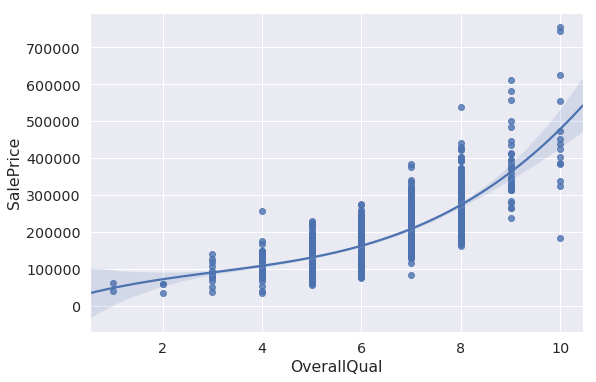

/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


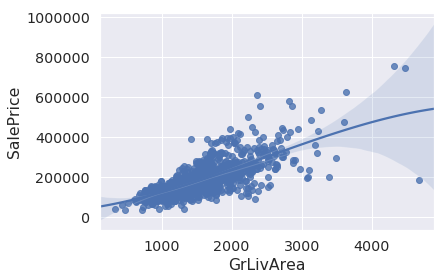

/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


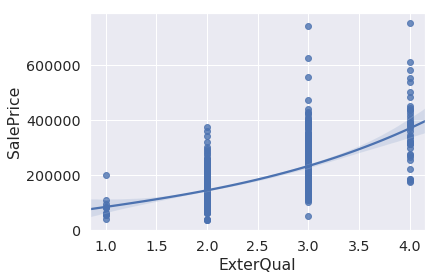

In [53]:
fig = plt.figure(figsize=(30,20))
for feature in top_corr_cols[1:4]:
    ax = fig.add_subplot(331); g = sns.regplot(x = house_data_num[feature], y = house_data_num.SalePrice, order=3)
    sns.set(font_scale=1.3)
    plt.show()

In [54]:
house_data_num = pd.concat([train_data_num, prices], axis = 1)
index = train_data_num[((train_data_num.GrLivArea > 4000) & (prices < 200000))].index
train_data_num = train_data_num.drop(index)
prices = prices.drop(index)
train_data_cat = train_data_cat.drop(index)


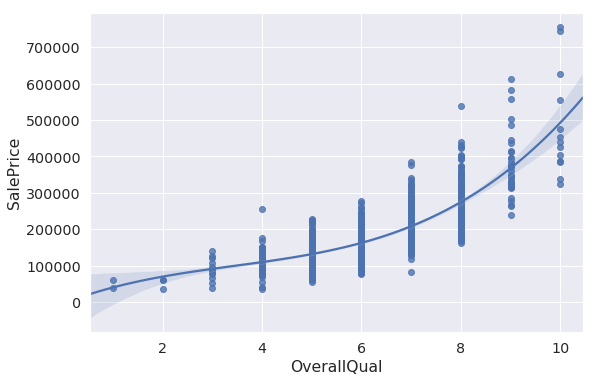

/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


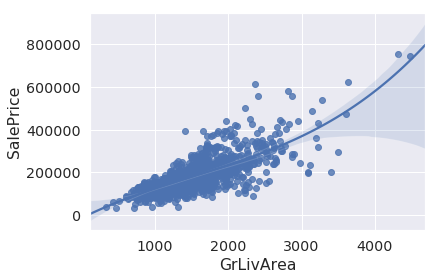

/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


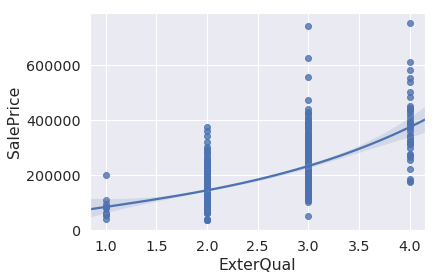

In [55]:
fig = plt.figure(figsize=(30,20))
for feature in top_corr_cols[1:4]:
    ax = fig.add_subplot(331); g = sns.regplot(x = train_data_num[feature], y = prices, order=3)
    sns.set(font_scale=1.3)
    plt.show()

In [56]:
#remove useless columns for the columns: the ones where for a given value of a column all the instances are almost there
for key in list(train_data_cat[:-1]):
    percentages = np.asarray(train_data_cat.groupby(key).size()/len(train_data_cat))
    for i in range(len(percentages)):
        if percentages[i]>0.93:
            train_data_cat = train_data_cat.drop(columns=key)
            break

In [57]:
normalizer = RobustScaler()
df_normalized = pd.DataFrame(normalizer.fit_transform(train_data_num))

In [64]:
#to perform regression with categorical values, it is necessary to dummy encode the categories
#if a feature has n categories (n as extracted by the training data), n binary features are created
#only one of these new features can be equal to 1 for each entry
train_data_cat_dummy =  pd.get_dummies(train_data_cat)

#solve problems of index resetting
train_data_cat_dummy = train_data_cat_dummy.reset_index(drop=True)
df_normalized = df_normalized.reset_index(drop=True)

#rebuild the original dataset with all characteristics (categorical + numerical)
norm_data = pd.concat([train_data_cat_dummy,df_normalized], axis = 1)

In [65]:
print(df_normalized.shape)
print(train_data_cat_dummy.shape)
print(prices.shape)
print(norm_data.shape)

(1199, 54)
(1199, 141)
(1199,)
(1199, 195)


Should we evaluate year? instead of having year, use something like age?

In [74]:

x_train, x_test, y_train, y_test = train_test_split(norm_data, prices, test_size = 0.3)
model = LinearRegression()
model.fit(x_train,y_train)
y_predict = np.array(model.predict(x_test))

In [75]:
from sklearn import metrics
print("Root Mean square error: " , np.sqrt(metrics.mean_squared_error(np.log(np.abs(y_test)),np.log(np.abs(y_predict)))))
results = pd.DataFrame()
results['TRUE'] = y_test
results['PREDICT'] = y_predict

Root Mean square error:  0.15879533290088332


In [79]:
#tol = 0.00001
x_train, x_test, y_train, y_test = train_test_split(norm_data, prices, test_size = 0.3)
model = Lasso(alpha=0.5,max_iter=1000, tol = 0.00001)
#model = Lasso(alpha=0.5,max_iter=1000,selection="random")
model.fit(x_train,y_train)
y_predict = np.array(model.predict(x_test))
print("Root Mean square error: " , np.sqrt(metrics.mean_squared_error(np.log(np.abs(y_test)),np.log(np.abs(y_predict)))))
results = pd.DataFrame()
results['TRUE'] = y_test
results['PREDICT'] = y_predict

Root Mean square error:  0.17802297476910817


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [80]:
#PIETRO
#tol = 0.00001
x_train, x_test, y_train, y_test = train_test_split(norm_data, prices, test_size = 0.3)
model = Lasso(max_iter=1000, tol = 0.00001)
#model = Lasso(alpha=0.5,max_iter=1000,selection="random")
model.fit(x_train,y_train)
y_predict = np.array(model.predict(x_test))
print("Root Mean square error: " , np.sqrt(metrics.mean_squared_error(np.log(np.abs(y_test)),np.log(np.abs(y_predict)))))
coef = pd.Series(model.coef_, index = x_train.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

#UTILE ANALISI RGIRUADO QUALI FEATURES ESCLUSE!

Root Mean square error:  0.17882861833378888
Lasso picked 181 variables and eliminated the other 14 variables


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [82]:
# normalize the data
knn = neighbors.KNeighborsRegressor(n_neighbors=19, weights='distance') # initialize the model
knn.fit(x_train, y_train) # fit the train data
y_predict = np.array(knn.predict(x_test))
print("Root Mean square error: " , np.sqrt(metrics.mean_squared_error(np.log(np.abs(y_test)),np.log(np.abs(y_predict)))))
results = pd.DataFrame()
results['TRUE'] = y_test
results['PREDICT'] = y_predict

Root Mean square error:  0.2539697791772055


<div class="">
    <h4> PCA</h4>
</div>

In [121]:
pca = PCA(50)
reduced_data = pca.fit_transform(norm_data)
print(norm_data.shape)
reduced_data.shape

(1199, 195)


(1199, 50)

In [122]:
#tol = 0.00001
x_train, x_test, y_train, y_test = train_test_split(reduced_data, prices, test_size = 0.3)
model = Lasso(alpha=0.5,max_iter=1000, tol = 0.00001)
#model = Lasso(alpha=0.5,max_iter=1000,selection="random")
model.fit(x_train,y_train)
y_predict = np.array(model.predict(x_test))
print("Root Mean square error: " , np.sqrt(metrics.mean_squared_error(np.log(np.abs(y_test)),np.log(np.abs(y_predict)))))
results = pd.DataFrame()
results['TRUE'] = y_test
results['PREDICT'] = y_predict

Root Mean square error:  0.162999624544545


In [160]:
#NICOLA

<div class="">
    <h3>3. Model Selection</h3>
</div>

Perhaps the most important segment of this challenge involves the selection of a model that can successfully handle the given data and yield sensible predictions.
Instead of focusing exclusively on your final chosen model, it is also important to share your thought process in this notebook by additionally describing alternative candidate models.
There is a wealth of models to choose from, such as <i>decision trees</i>, <i>random forests</i>, <i>(Bayesian) neural networks</i>, <i>Gaussian processes</i>, <i>LASSO regression</i>, and so on.
There are several factors which may influence your decision:

- What is the model's complexity?
- Is the model interpretable?
- Is the model capable of handling different data-types?
- Does the model return uncertainty estimates along with predictions?

An in-depth evaluation of competing models in view of this and other criteria will elevate the quality of your submission and earn you a higher grade.


<div class="">
    <h3>4. Parameter Optimisation</h3>
</div>

Irrespective of your choice, it is highly likely that your model will have one or more parameters that require tuning.
There are several techniques for carrying out such a procedure, including cross-validation, Bayesian optimisation, and several others.
As before, an analysis into which parameter tuning technique best suits your model is expected before proceeding with the optimisation of your model.

<div class="">
    <h3>5. Model Evaluation</h3>
</div>

Some form of pre-evaluation will inevitably be required in the preceding sections in order to both select an appropriate model and configure its parameters appropriately.
In this final section, you may evaluate other aspects of the model such as:

- Assessing the running time of your model;
- Determining whether some aspects can be parallelised;
- Training the model with smaller subsets of the data.
- etc.

<div class="alert alert-danger">
    <b>N.B.</b> Please note that the items listed under each heading are neither exhaustive, nor are you expected to explore every given suggestion.
    Nonetheless, these should serve as a guideline for your work in both this and upcoming challenges.
    As always, you should use your intuition and understanding in order to decide which analysis best suits the assigned task.
</div>

<div class="">
    <h2>Submission Instructions</h2>
    <hr style="height:1px;border:none;color:#333;background-color:#333;" />    
</div>

- The goal of this challenge is to construct a model for predicting house prices;
<br><br>

- Your submission will have two components:

    1. An <b>HTML version of your notebook</b> exploring the various modelling aspects described above;
    2. A CSV file containing your <b>final model's predictions on the given test data</b>. 
       This file should contain a header and have the following format:
       
        ```
        Id,SalePrice
        1461,169000.1
        1462,187724.1233
        1463,175221
        etc.
        ```
        
        An example submission file has been provided in the data directory of the repository.
        A leaderboard for this challenge will be ranked using the root mean squared error between the logarithm of the predicted value and the logarithm of the observed sales price. 
        Taking logs ensures that errors in predicting expensive houses and cheap houses will have a similar impact on the overall result;
<br><br>
- This exercise is due on <b>04/04/2019</b>.

<div class="">
    <h2>Dataset Description</h2>
    <hr style="height:1px;border:none;color:#333;background-color:#333;"/>    
</div>

#### * Files

* train.csv - The training dataset;
* test.csv - The test dataset;
* data_description.txt - Full description of each column.

#### * Attributes

A brief outline of the available attributes is given below:

* <i>SalePrice</i>: The property's sale price in dollars. This is the target variable that your model is intended to predict;

* <i>MSSubClass</i>: The building class;
* <i>MSZoning</i>: The general zoning classification;
* <i>LotFrontage</i>: Linear feet of street connected to property;
* <i>LotArea</i>: Lot size in square feet;
* <i>Street</i>: Type of road access;
* <i>Alley</i>: Type of alley access;
* <i>LotShape</i>: General shape of property;
* <i>LandContour</i>: Flatness of the property;
* <i>Utilities</i>: Type of utilities available;
* <i>LotConfig</i>: Lot configuration;
* <i>LandSlope</i>: Slope of property;
* <i>Neighborhood</i>: Physical locations within Ames city limits;
* <i>Condition1</i>: Proximity to main road or railroad;
* <i>Condition2</i>: Proximity to main road or railroad (if a second is present);
* <i>BldgType</i>: Type of dwelling;
* <i>HouseStyle</i>: Style of dwelling;
* <i>OverallQual</i>: Overall material and finish quality;
* <i>OverallCond</i>: Overall condition rating;
* <i>YearBuilt</i>: Original construction date;
* <i>YearRemodAdd</i>: Remodel date;
* <i>RoofStyle</i>: Type of roof;
* <i>RoofMatl</i>: Roof material;
* <i>Exterior1st</i>: Exterior covering on house;
* <i>Exterior2nd</i>: Exterior covering on house (if more than one material);
* <i>MasVnrType</i>: Masonry veneer type;
* <i>MasVnrArea</i>: Masonry veneer area in square feet;
* <i>ExterQualv</i>: Exterior material quality;
* <i>ExterCond</i>: Present condition of the material on the exterior;
* <i>Foundation</i>: Type of foundation;
* <i>BsmtQual</i>: Height of the basement;
* <i>BsmtCond</i>: General condition of the basement;
* <i>BsmtExposure</i>: Walkout or garden level basement walls;
* <i>BsmtFinType1</i>: Quality of basement finished area;
* <i>BsmtFinSF1</i>: Type 1 finished square feet;
* <i>BsmtFinType2</i>: Quality of second finished area (if present);
* <i>BsmtFinSF2</i>: Type 2 finished square feet;
* <i>BsmtUnfSF</i>: Unfinished square feet of basement area;
* <i>TotalBsmtSF</i>: Total square feet of basement area;
* <i>Heating</i>: Type of heating;
* <i>HeatingQC</i>: Heating quality and condition;
* <i>CentralAir</i>: Central air conditioning;
* <i>Electrical</i>: Electrical system;
* <i>1stFlrSF</i>: First Floor square feet;
* <i>2ndFlrSF</i>: Second floor square feet;
* <i>LowQualFinSF</i>: Low quality finished square feet (all floors);
* <i>GrLivArea</i>: Above grade (ground) living area square feet;
* <i>BsmtFullBath</i>: Basement full bathrooms;
* <i>BsmtHalfBath</i>: Basement half bathrooms;
* <i>FullBath</i>: Full bathrooms above grade;
* <i>HalfBath</i>: Half baths above grade;
* <i>Bedroom</i>: Number of bedrooms above basement level;
* <i>Kitchen</i>: Number of kitchens;
* <i>KitchenQual</i>: Kitchen quality;
* <i>TotRmsAbvGrd</i>: Total rooms above grade (does not include bathrooms);
* <i>Functional</i>: Home functionality rating;
* <i>Fireplaces</i>: Number of fireplaces;
* <i>FireplaceQu</i>: Fireplace quality;
* <i>GarageType</i>: Garage location;
* <i>GarageYrBlt</i>: Year garage was built;
* <i>GarageFinish</i>: Interior finish of the garage;
* <i>GarageCars</i>: Size of garage in car capacity;
* <i>GarageArea</i>: Size of garage in square feet;
* <i>GarageQual</i>: Garage quality;
* <i>GarageCond</i>: Garage condition;
* <i>PavedDrive</i>: Paved driveway;
* <i>WoodDeckSF</i>: Wood deck area in square feet;
* <i>OpenPorchSF</i>: Open porch area in square feet;
* <i>EnclosedPorch</i>: Enclosed porch area in square feet;
* <i>3SsnPorch</i>: Three season porch area in square feet;
* <i>ScreenPorch</i>: Screen porch area in square feet;
* <i>PoolArea</i>: Pool area in square feet;
* <i>PoolQC</i>: Pool quality;
* <i>Fence</i>: Fence quality;
* <i>MiscFeature</i>: Miscellaneous feature not covered in other categories;
* <i>MiscVal</i>: Value (in dollars) of miscellaneous feature;
* <i>MoSold</i>: Month sold;
* <i>YrSold</i>: Year sold;
* <i>SaleType</i>: Type of sale;
* <i>SaleCondition</i>: Condition of sale.
